# LMDZORnudge-uvt-1dall-noBL-STD-NY07

conda env: new `phd_v3` (in `envs/phd`)

## LMDZORnudge-STD-NY07

- Jean-Zay WORK: `/gpfsdswork/projects/rech/goe/ufz23bm/SCA_parameterization/modipsl/config/LMDZOR_v6/LMDZORnudge-STD-NY07`
- Jean-Zay STORE: `/gpfsstore/rech/goe/ufz23bm/IGCM_OUT/LMDZOR/DEVT/amip/LMDZORnudge-STD-NY07`
- THREDDS: `/gpfsdsmnt/ipsl/dods/pub/ufz23bm/LMDZOR/DEVT/amip/LMDZORnudge-STD-NY07`
- CICLAD: `/thredds/idris/work/ufz23bm/LMDZOR/DEVT/amip/LMDZORnudge-STD-NY07` 
- https://vesg.ipsl.upmc.fr/thredds/catalog/idris_work/ufz23bm/LMDZOR/DEVT/amip/LMDZORnudge-STD-NY07/catalog.html


## LMDZORnudge-uvt-1dall-noBL-STD-NY07

- Jean-Zay WORK: `/gpfswork/rech/goe/ufz23bm/SCA_parameterization/modipsl/config/LMDZOR_v6/LMDZORnudge-uvt-1dall-noBL-STD-NY07`
- Jean-Zay STORE: `/gpfsscratch/rech/goe/ufz23bm/IGCM_OUT/LMDZOR/PRDEVTD/amip/LMDZORnudge-uvt-1dall-noBL-STD-NY07`
- THREDDS: `/gpfsdsmnt/ipsl/dods/pub/ufz23bm/LMDZOR/DEVT/amip/LMDZORnudge-uvt-1dall-noBL-STD-NY07`
- CICLAD: `/thredds/idris/work/ufz23bm/LMDZOR/DEVT/amip/LMDZORnudge-uvt-1dall-noBL-STD-NY07` 
- https://vesg.ipsl.upmc.fr/thredds/catalog/idris_work/ufz23bm/LMDZOR/DEVT/amip/LMDZORnudge-uvt-1dall-noBL-STD-NY07/catalog.html

## Import modules

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Define paths

In [2]:
root = '/thredds/idris/work/ufz23bm/LMDZOR/DEVT/amip/'
exp_ref = 'LMDZORnudge-STD-NY07'
exp_new = 'LMDZORnudge-uvt-1dall-noBL-STD-NY07'

In [3]:
# !ls /thredds/idris/work/ufz23bm/IGCM_OUT/LMDZOR/PROD/clim/LMDZOR-STD-REF/ATM/Analyse/TS_MO/

## Make function to get data

In [3]:
def get_data(list_vars, period, season, zone):
    """
        Get reference and new experiments + observations.

        Parameters
        ----------
        list_vars : list
            List of variables. Options are: 'frac_snow', 't2m', 'precip', 'ta'
        period : slice
            Period
        season : str
            Season (ex: 'annual', 'DJF', '1')
        zone : str
            Zone of study (ex: 'HMA', 'GLOB', 'NH')

        Returns
        -------
        ref, new, obs : list of Dataset
            List of reference and new experiments + observations regrided on model dataset (not 
            loaded) for each variable.
            
        clim_ref, clim_new, clim_obs : list of DataArray
            List of reference and new experiments + observations regrided on model climatologies
            for each variable.

        Example
        -------
        >>>  list_ref, list_new, list_obs, list_clim_ref, list_clim_new, list_clim_obs = get_data(
                ['frac_snow', 't2m', 'precip'], slice('1981','1989'), 'annual', 'GLOB'
            )

    """
    
    list_ref = []
    list_new = []
    list_obs = []
    list_clim_ref = []
    list_clim_new = []
    list_clim_obs = []
       
    list_var_SRF = ['frac_snow']
    list_var_ATM = ['t2m', 'precip', 'ta']
    latlim, lonlim = u.get_zone(zone)

    for var in list_vars:

        print(
            f"""
    #############
    ### Variable: {var} 
    #############
            """
        )

        if var in list_var_SRF:
            component = 'SRF'
        elif var in list_var_ATM:
            component = 'ATM'
        else:
            raise ValueError(f"Invalid var argument: '{var}'. Valid names are: 'frac_snow'.")

        path = root+exp_ref+'/'+component+'/Analyse/TS_MO/'+exp_ref+'_20040101_20131231_1M_'+var+'.nc'
        print('Open reference simulation:\n'+path+'\n')
        ref = xr.open_dataset(path)[var]
        ref.attrs['title'] = exp_ref

        path = root+exp_new+'/'+component+'/Analyse/TS_MO/'+exp_new+'_20040101_20081231_1M_'+var+'.nc'
        print('Open new simulation:\n'+path+'\n')
        new = xr.open_dataset(path)[var]
        new.attrs['title'] = exp_new

        # Rename time dimension and sort latitude from -90 to 90
        ref = ref.rename({'time_counter': 'time'}).sortby('lat')
        new = new.rename({'time_counter': 'time'}).sortby('lat')

        # Compute climatolgy
        clim_ref = u.clim(
            ref.sel(time=period, lat=latlim, lon=lonlim), season=season, calendar='standard')
        clim_ref.attrs['season'] = season
        clim_ref.attrs['zone'] = zone

        clim_new = u.clim(
            new.sel(time=period, lat=latlim, lon=lonlim), season=season, calendar='standard')
        clim_new.attrs['season'] = season
        clim_new.attrs['zone'] = zone

        # Unit conversion
        if var in ['tas', 'tmp', 't2m', 'ta']:
            with xr.set_options(keep_attrs=True):
                clim_ref -= 273.15
                clim_new -= 273.15
            clim_ref.attrs['units'] = '°C'
            clim_new.attrs['units'] = '°C'

            if var in ['ta']:
                clim_ref = clim_ref.assign_coords({'plev': clim_ref.plev/100}).rename({'plev': 'level'})
                clim_new = clim_new .assign_coords({'plev': clim_new.plev/100}).rename({'plev': 'level'})

        elif var in ['pr', 'precip']:
            with xr.set_options(keep_attrs=True):
                clim_ref *= 86400
                clim_new *= 86400
            clim_ref.attrs['units'] = 'mm/day'
            clim_new.attrs['units'] = 'mm/day'

        # Get observations
        if var in ['snc', 'frac_snow']:
#             obs_name = 'NH_SCE_CDR'
#             version = 'v01r01'
            obs_name = 'snowCCI_MODIS'
            version = 'v2.0'
        elif var in ['tas', 'tmp', 't2m']:
            obs_name = 'CRU_TS'
            version = '4.04'
        elif var in ['pr', 'precip']:
            obs_name = 'APHRO_MA'
            version = 'V1101'
        elif var in ['ta']:
            obs_name = 'ERAI'
            version = ''

        obs = u.get_obs(obs_name, version, var, period=period, machine='CICLAD', regrid=clim_ref)
        clim_obs = u.clim(
            obs.sel(time=period, lat=latlim, lon=lonlim), season=season, calendar='standard')
        
        list_ref.append(ref)
        list_new.append(new)
        list_obs.append(obs)
        list_clim_ref.append(clim_ref)
        list_clim_new.append(clim_new)
        list_clim_obs.append(clim_obs)
               
    return list_ref, list_new, list_obs, list_clim_ref, list_clim_new, list_clim_obs

## Plot differences and compare to observation

### HMA

#### Get data

In [4]:
# list_vars = ['frac_snow']
list_vars = ['frac_snow', 't2m', 'precip']

# Period for climatologies (removing first year spin-up)
period = slice('2005','2008')
season = 'annual'
zone = 'HMA'

list_ref, list_new, list_obs, list_clim_ref, list_clim_new, list_clim_obs = get_data(
    list_vars, period, season, zone)


    #############
    ### Variable: frac_snow 
    #############
            
Open reference simulation:
/thredds/idris/work/ufz23bm/LMDZOR/DEVT/amip/LMDZORnudge-STD-NY07/SRF/Analyse/TS_MO/LMDZORnudge-STD-NY07_20040101_20131231_1M_frac_snow.nc

Open new simulation:
/thredds/idris/work/ufz23bm/LMDZOR/DEVT/amip/LMDZORnudge-uvt-1dall-noBL-STD-NY07/SRF/Analyse/TS_MO/LMDZORnudge-uvt-1dall-noBL-STD-NY07_20040101_20081231_1M_frac_snow.nc

Get observation: snowCCI_MODIS
/data/mlalande/ESA_CCI_SNOW/preprocess/scfg/MODIS/v2.0/monthly_0.5deg/*.nc

Reuse existing file: bilinear_360x720_24x21_peri.nc

    #############
    ### Variable: t2m 
    #############
            
Open reference simulation:
/thredds/idris/work/ufz23bm/LMDZOR/DEVT/amip/LMDZORnudge-STD-NY07/ATM/Analyse/TS_MO/LMDZORnudge-STD-NY07_20040101_20131231_1M_t2m.nc

Open new simulation:
/thredds/idris/work/ufz23bm/LMDZOR/DEVT/amip/LMDZORnudge-uvt-1dall-noBL-STD-NY07/ATM/Analyse/TS_MO/LMDZORnudge-uvt-1dall-noBL-STD-NY07_20040101_20081

/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Reuse existing file: bilinear_140x180_24x21.nc


/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


#### Make plots

/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


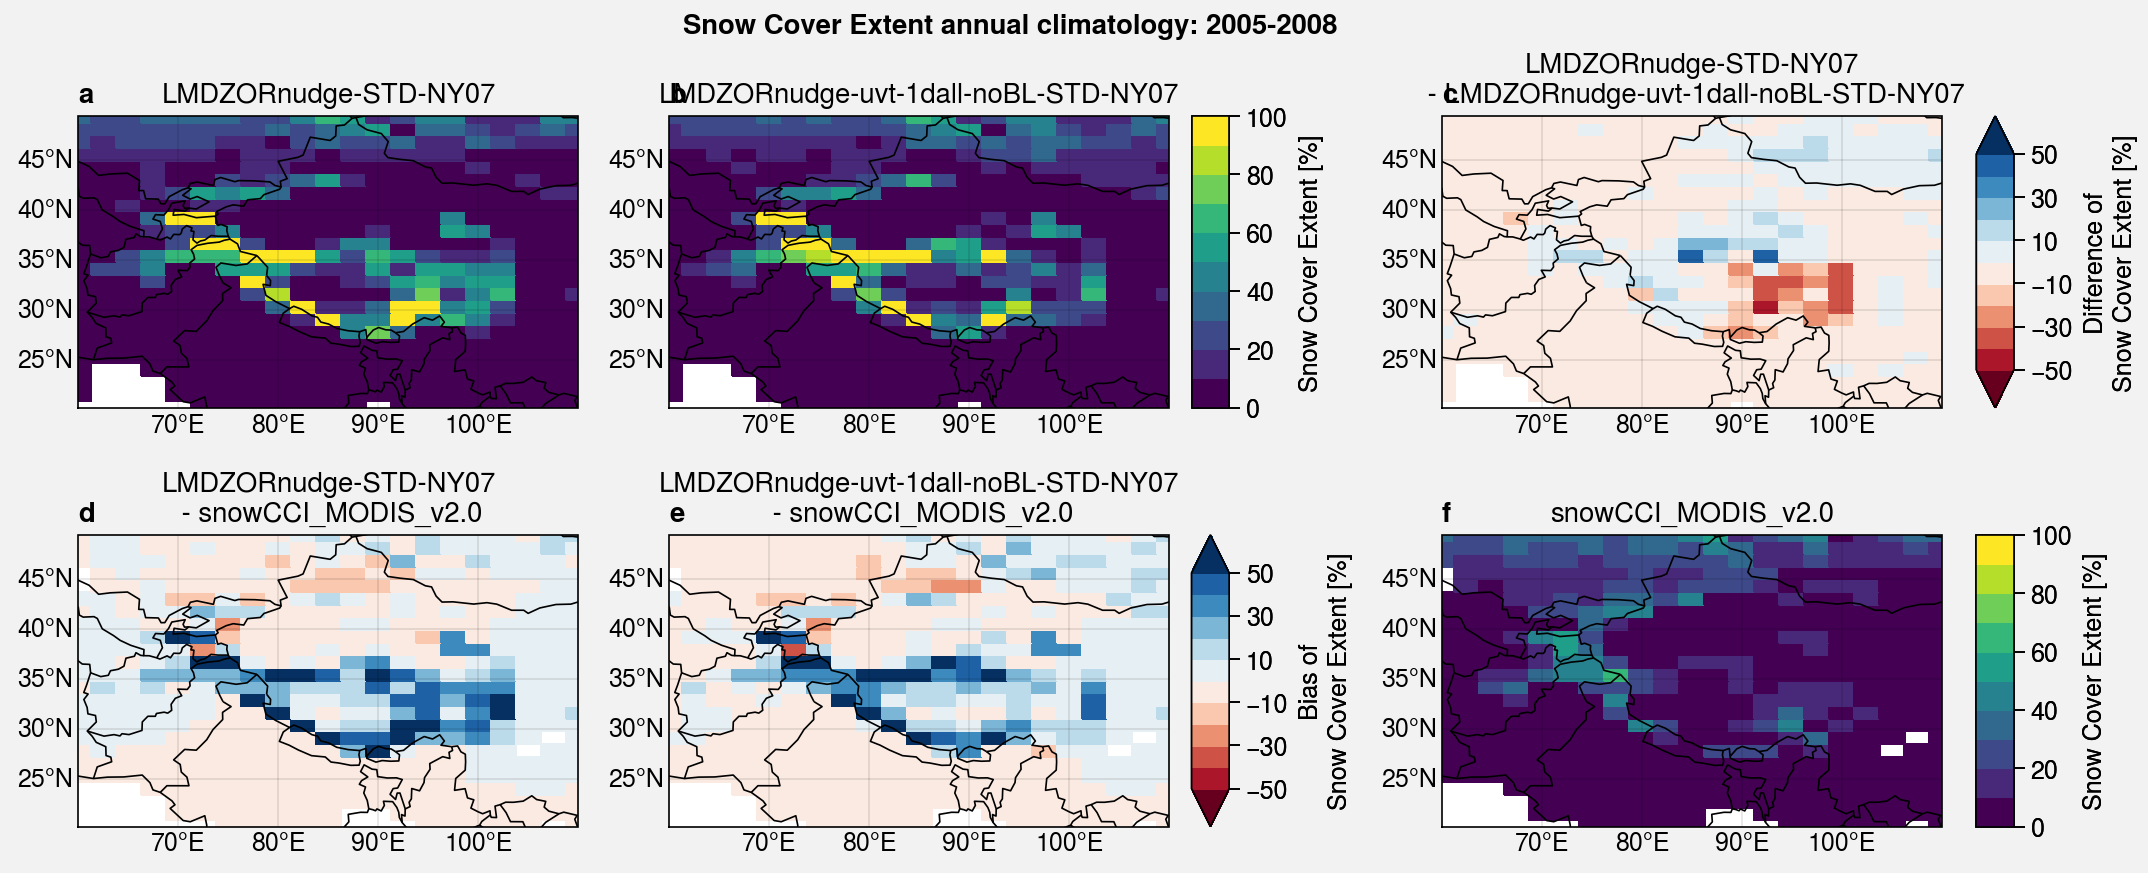

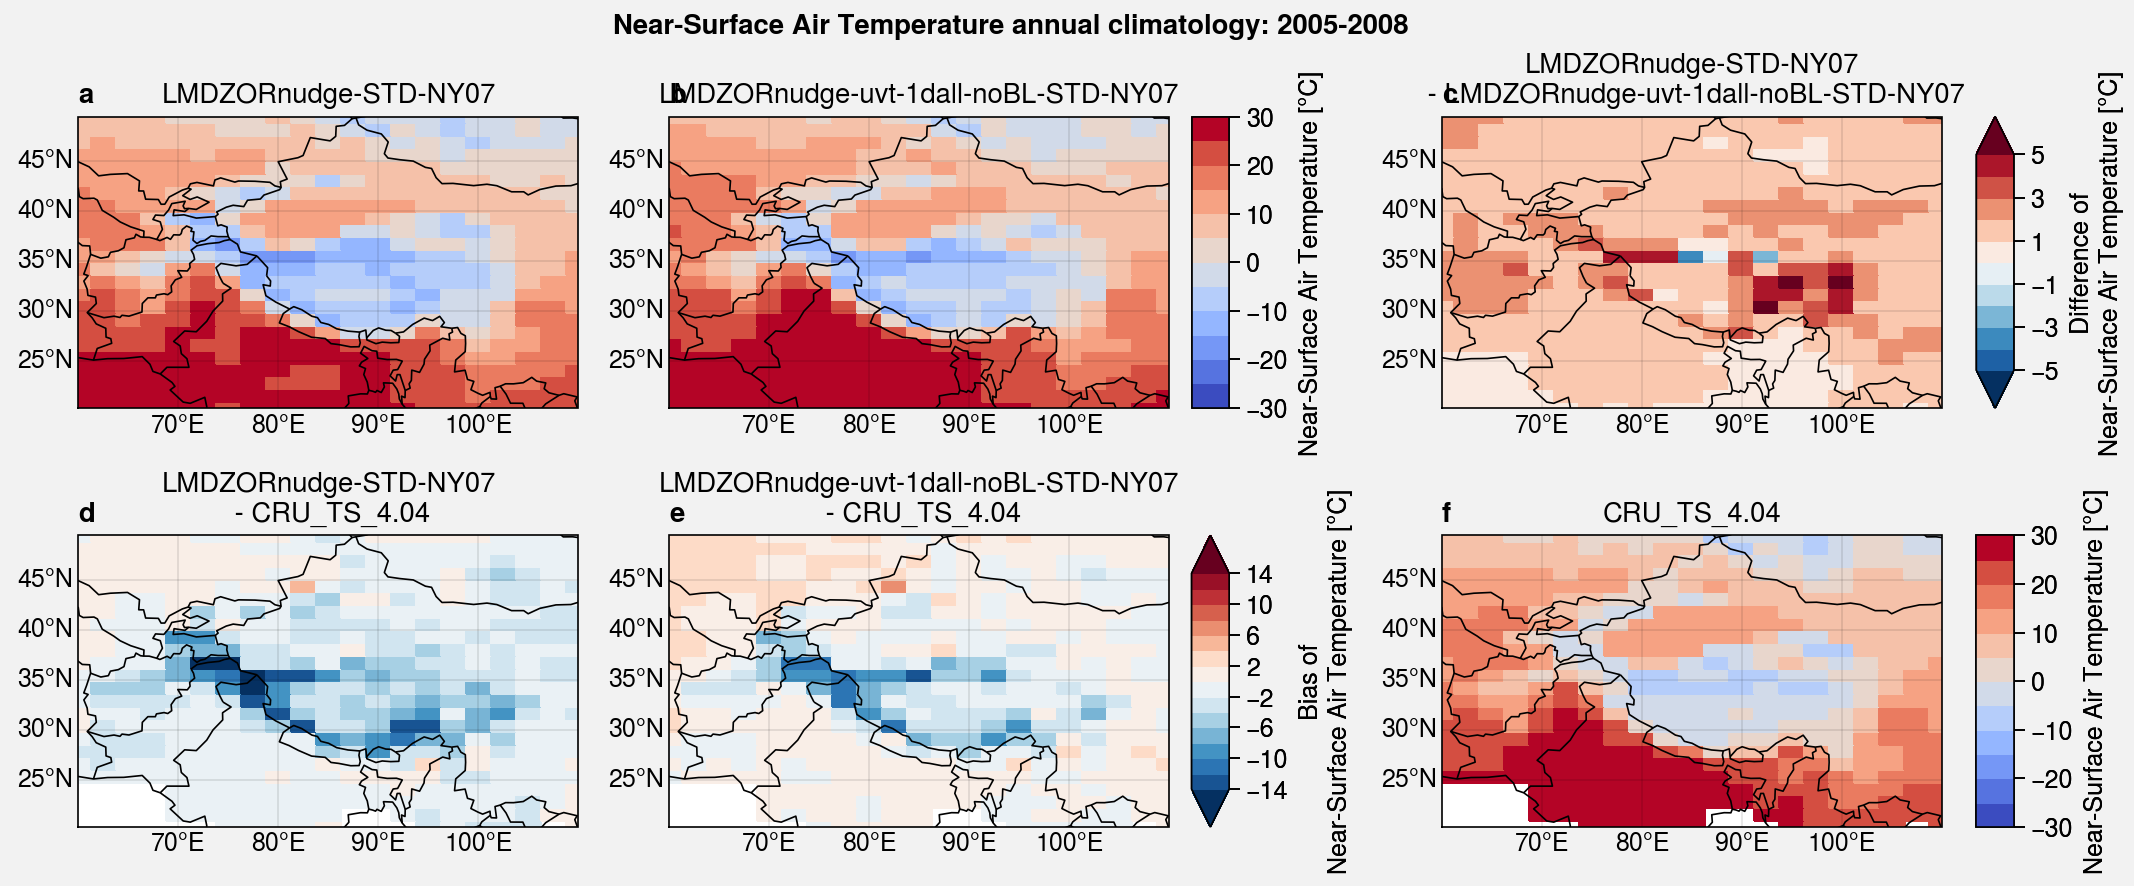

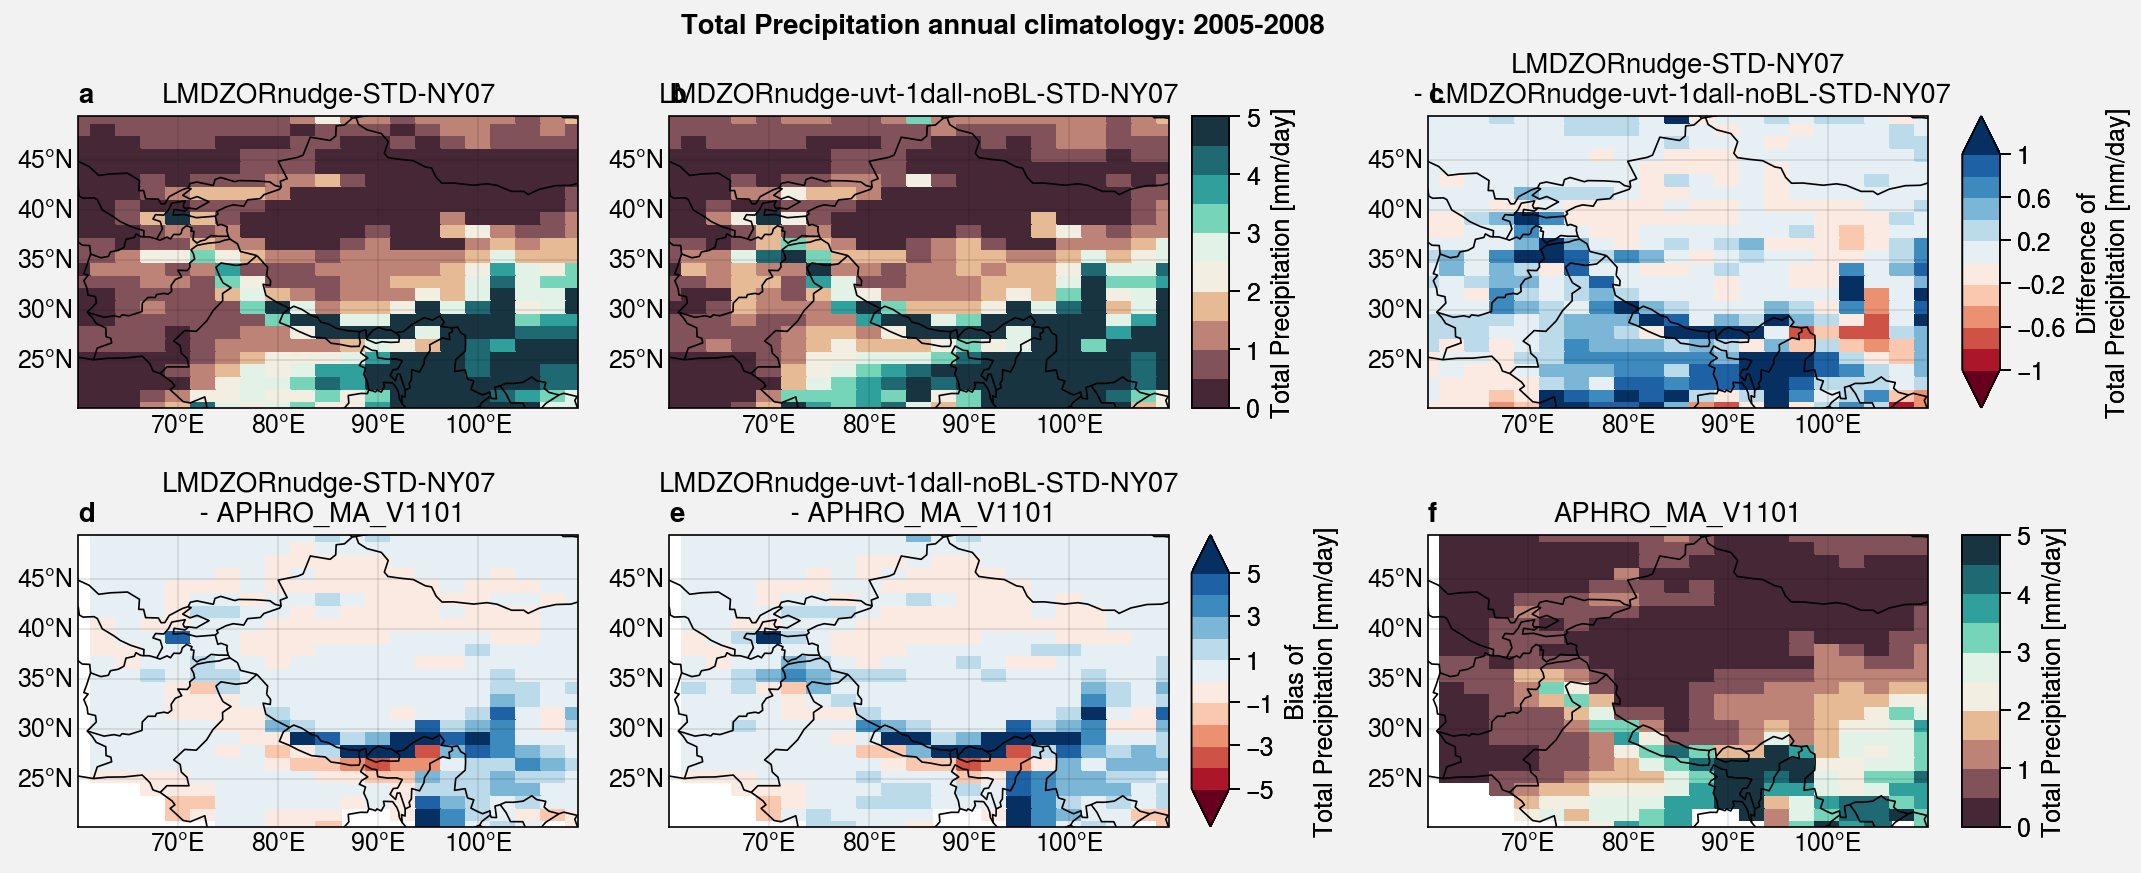

In [5]:
for i, var in enumerate(list_vars):
    label, units, \
    levels, cmap, extend, \
    levels_diff, cmap_diff, extend_diff, \
    levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)

    u.plot_ref_new_obs(
        var, list_clim_ref[i], list_clim_new[i], list_clim_obs[i], label, units,
        levels, cmap, extend,
        levels_diff, cmap_diff, extend_diff,
        levels_bias, cmap_bias, extend_bias,
        save=False, dpi=300
    )

### Northern Hemisphere

#### Get data

In [9]:
# list_vars = ['frac_snow']
list_vars = ['frac_snow', 't2m']

# Period for climatologies (removing first year spin-up)
period = slice('2005','2008')
season = 'annual'
zone = 'NH'

list_ref, list_new, list_obs, list_clim_ref, list_clim_new, list_clim_obs = get_data(
    list_vars, period, season, zone)


    #############
    ### Variable: frac_snow 
    #############
            
Open reference simulation:
/thredds/idris/work/ufz23bm/LMDZOR/DEVT/amip/LMDZORnudge-STD-NY07/SRF/Analyse/TS_MO/LMDZORnudge-STD-NY07_20040101_20131231_1M_frac_snow.nc

Open new simulation:
/thredds/idris/work/ufz23bm/LMDZOR/DEVT/amip/LMDZORnudge-uvt-1dall-noBL-STD-NY07/SRF/Analyse/TS_MO/LMDZORnudge-uvt-1dall-noBL-STD-NY07_20040101_20081231_1M_frac_snow.nc

Get observation: snowCCI_MODIS
/data/mlalande/ESA_CCI_SNOW/preprocess/scfg/MODIS/v2.0/monthly_0.5deg/*.nc

Reuse existing file: bilinear_360x720_72x144_peri.nc

    #############
    ### Variable: t2m 
    #############
            
Open reference simulation:
/thredds/idris/work/ufz23bm/LMDZOR/DEVT/amip/LMDZORnudge-STD-NY07/ATM/Analyse/TS_MO/LMDZORnudge-STD-NY07_20040101_20131231_1M_t2m.nc

Open new simulation:
/thredds/idris/work/ufz23bm/LMDZOR/DEVT/amip/LMDZORnudge-uvt-1dall-noBL-STD-NY07/ATM/Analyse/TS_MO/LMDZORnudge-uvt-1dall-noBL-STD-NY07_20040101_2008

#### Make plots

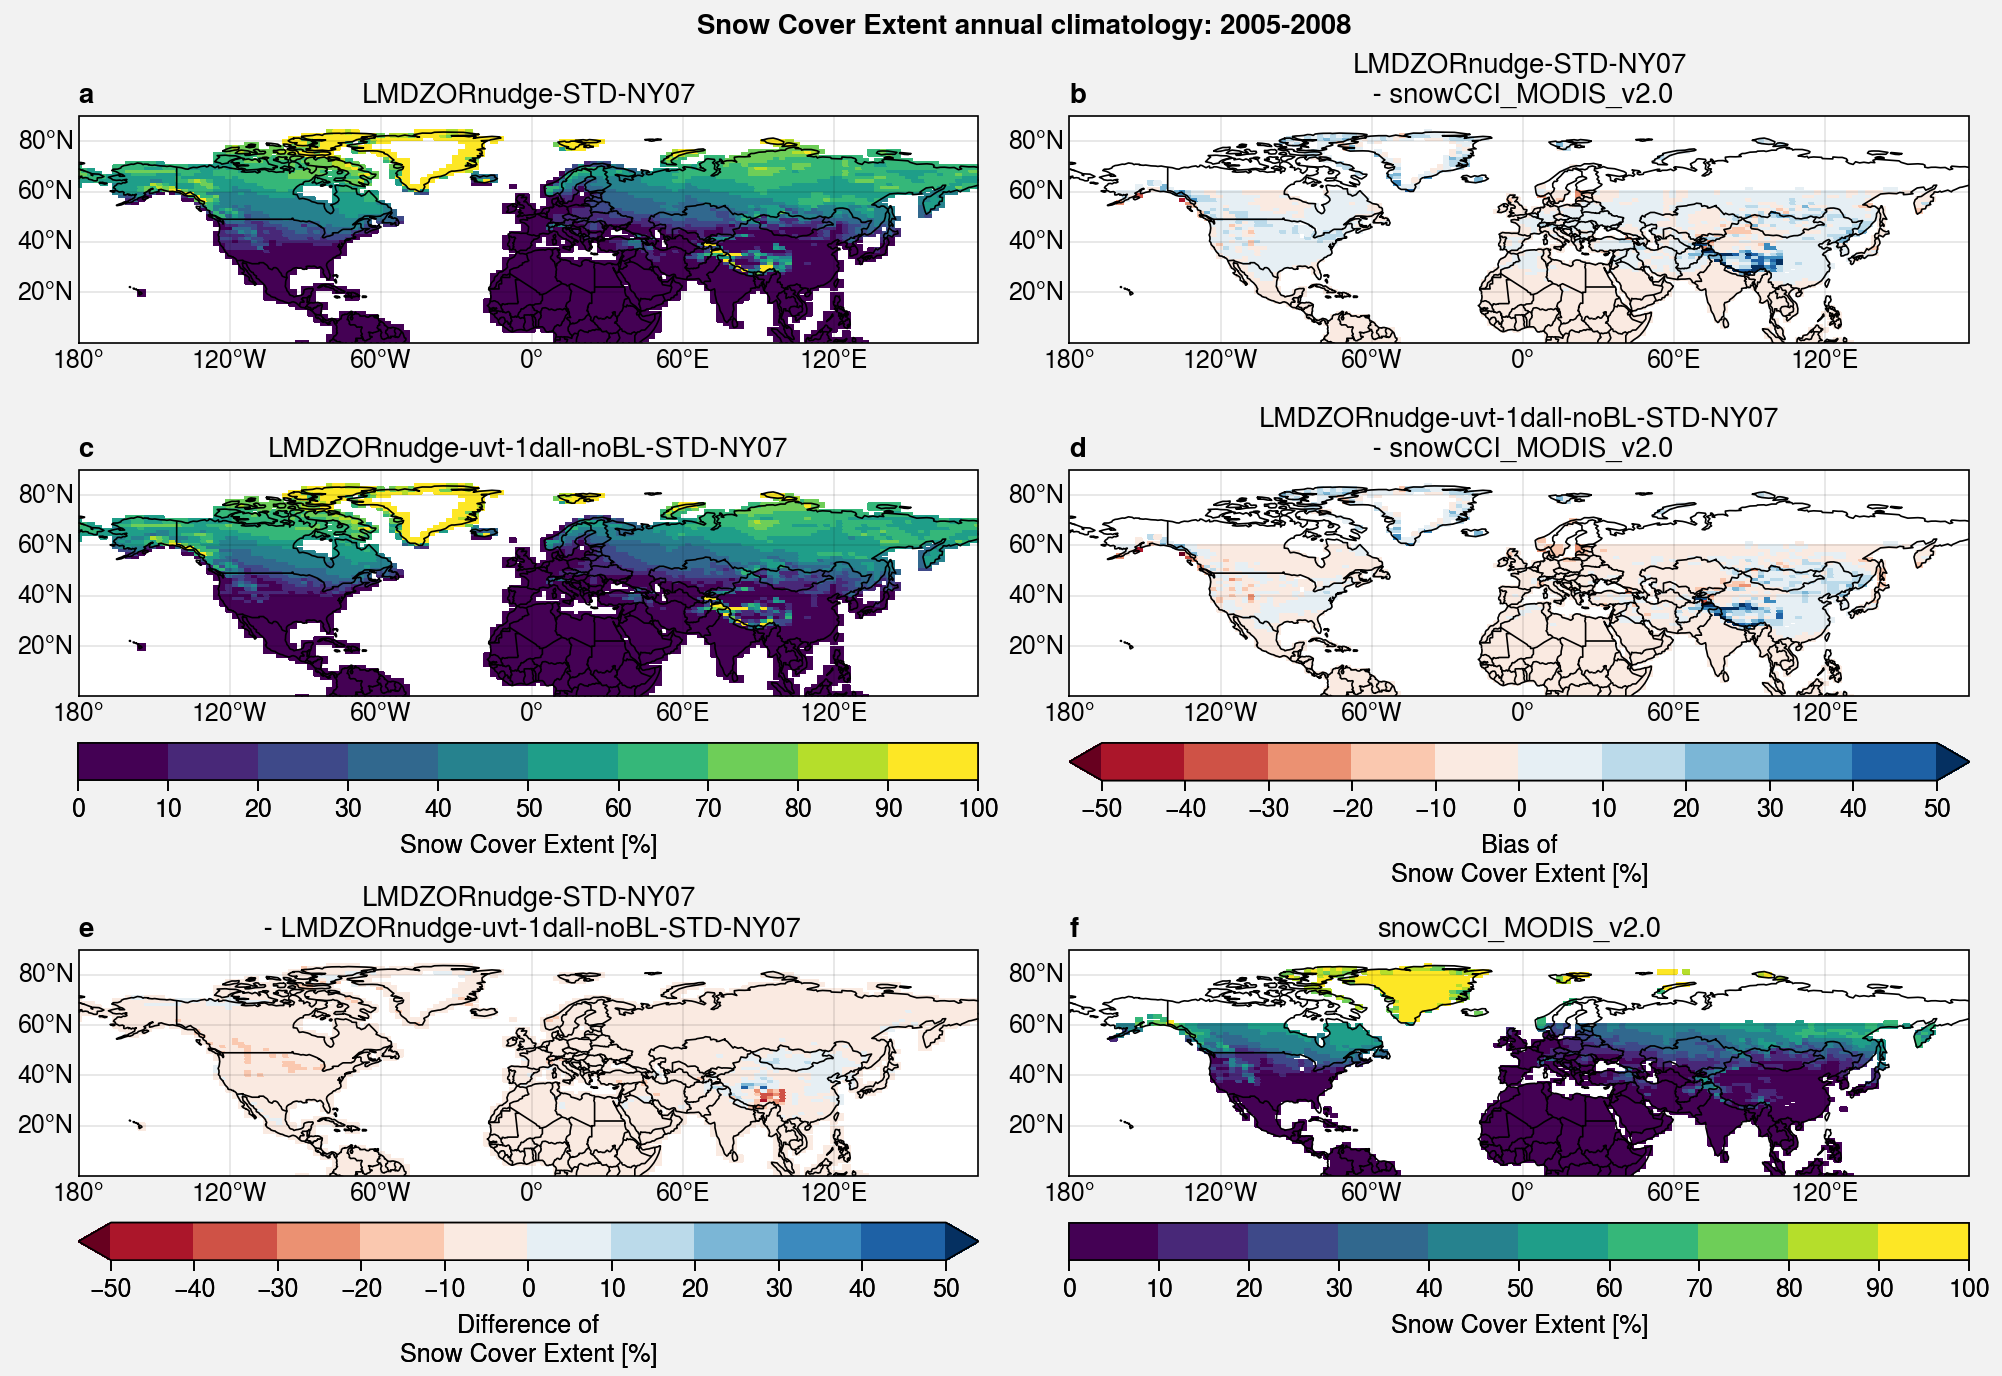

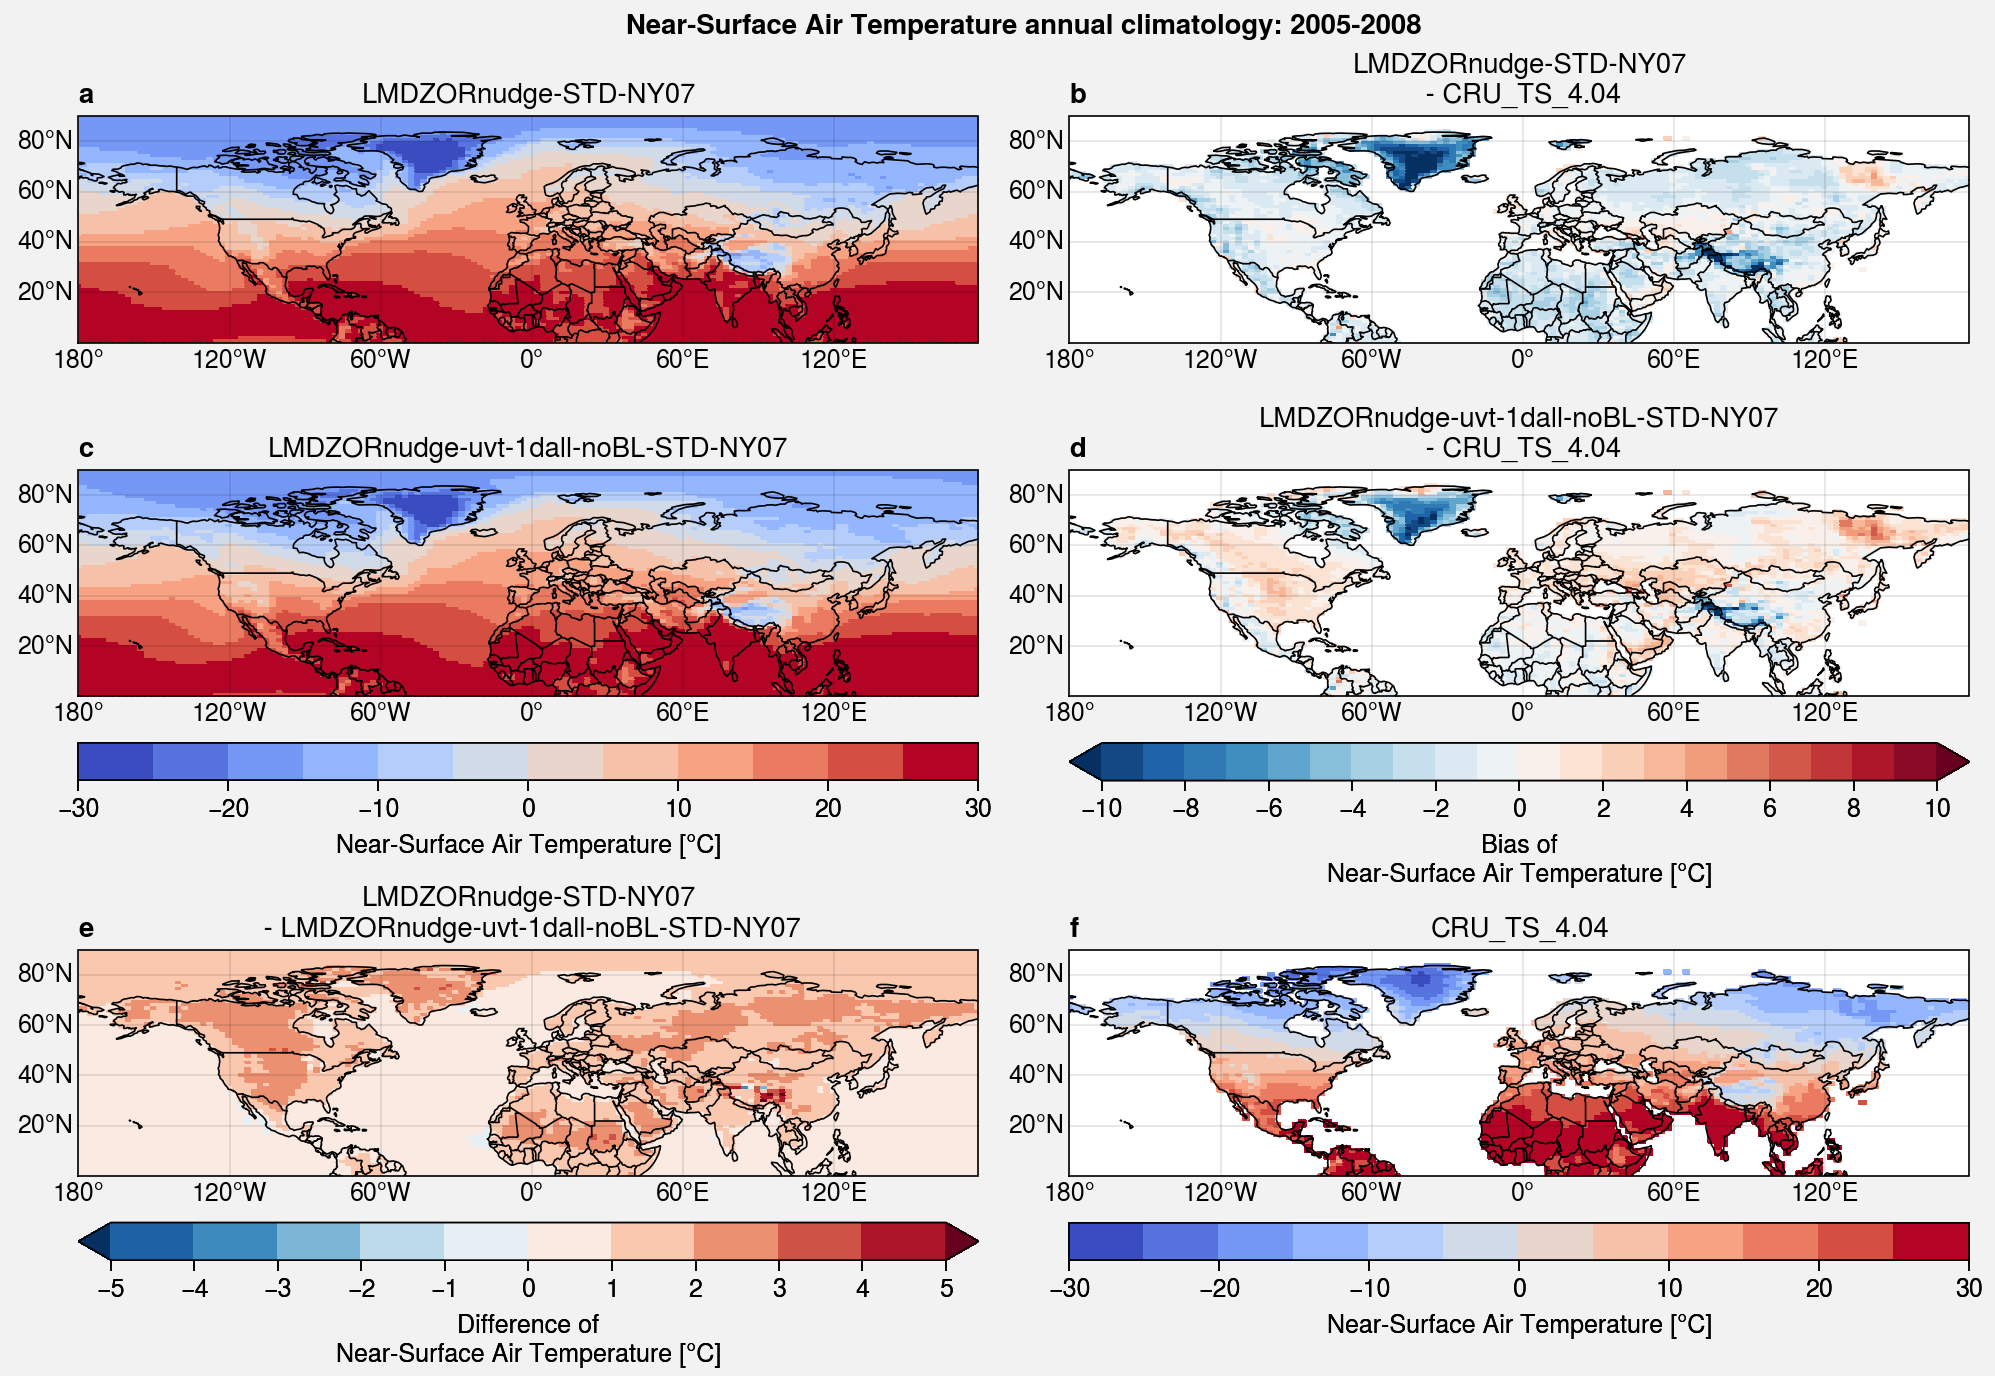

In [10]:
for i, var in enumerate(list_vars):
    label, units, \
    levels, cmap, extend, \
    levels_diff, cmap_diff, extend_diff, \
    levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)

    u.plot_ref_new_obs(
        var, list_clim_ref[i], list_clim_new[i], list_clim_obs[i], label, units,
        levels, cmap, extend,
        levels_diff, cmap_diff, extend_diff,
        levels_bias, cmap_bias, extend_bias,
        save=False, dpi=300
    )

### World topography
https://www.ngdc.noaa.gov/mgg/image/color_etopo1_ice_low.jpg

![](img/color_etopo1_ice_low.jpg)

## Zonal plots

### Global

#### Get data

In [8]:
list_vars = ['ta']

# Period for climatologies (removing first year spin-up)
period = slice('2005','2008')
season = 'annual'
zone = 'GLOB'

list_ref, list_new, list_obs, list_clim_ref, list_clim_new, list_clim_obs = get_data(
    list_vars, period, season, zone)


    #############
    ### Variable: ta 
    #############
            
Open reference simulation:
/thredds/idris/work/ufz23bm/LMDZOR/DEVT/amip/LMDZORnudge-STD-NY07/ATM/Analyse/TS_MO/LMDZORnudge-STD-NY07_20040101_20131231_1M_ta.nc

Open new simulation:
/thredds/idris/work/ufz23bm/LMDZOR/DEVT/amip/LMDZORnudge-uvt-1dall-noBL-STD-NY07/ATM/Analyse/TS_MO/LMDZORnudge-uvt-1dall-noBL-STD-NY07_20040101_20081231_1M_ta.nc



FileNotFoundError: [Errno 2] No such file or directory: b'/thredds/idris/work/ufz23bm/LMDZOR/DEVT/amip/LMDZORnudge-uvt-1dall-noBL-STD-NY07/ATM/Analyse/TS_MO/LMDZORnudge-uvt-1dall-noBL-STD-NY07_20040101_20081231_1M_ta.nc'

#### Make plots

In [ ]:
for i in range(len(list_vars)):
    list_clim_ref[i].load()
    list_clim_new[i].load()
    list_clim_obs[i].load()

In [ ]:
for i, var in enumerate(list_vars):
    label, units, \
    levels, cmap, extend, \
    levels_diff, cmap_diff, extend_diff, \
    levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)

    u.plot_zonal_bias_HMA(
        var, list_clim_ref[i], list_clim_new[i], list_clim_obs[i], label, units,
        levels_diff, cmap_diff, extend_diff,
        levels_bias, cmap_bias, extend_bias,
        save=False, dpi=300
    )

## SWE/SCE

Il faut récupérer les variables liées à la neige dans le TimeSeries !
- snow
- snowage
- snownobio
- snownobioage
- snowmelt
- snowmelt_from_maxmass
- pkappa_snow
- pcapa_snow
- snowtemp
- snowtemp_weighted
- snowliq
- snowdz
- snowrho
- snowheat
- snowgrain
- **snowdepth**
- frac_snow
- snowliqtot
- snowage_glob

In [12]:
# !ls /thredds/idris/work/ufz23bm/IGCM_OUT/LMDZOR/PROD/clim/LMDZOR-STD-REF/SRF/Analyse/TS_MO/

In [13]:
var = 'frac_snow'
component = 'SRF'

path = root+exp_ref+'/'+component+'/Analyse/TS_MO/'+exp_ref+'_20040101_20081231_1M_'+var+'.nc'
print('Open reference simulation:\n'+path+'\n')
frac_snow_ref = xr.open_dataset(path)[var]
frac_snow_ref.attrs['title'] = exp_ref

path = root+exp_new+'/'+component+'/Analyse/TS_MO/'+exp_new+'_20040101_20081231_1M_'+var+'.nc'
print('Open new simulation:\n'+path+'\n')
frac_snow_new = xr.open_dataset(path)[var]
frac_snow_new.attrs['title'] = exp_new

# Rename time dimension and sort latitude from -90 to 90
frac_snow_ref = frac_snow_ref.rename({'time_counter': 'time'}).sortby('lat')
frac_snow_new = frac_snow_new.rename({'time_counter': 'time'}).sortby('lat')

Open reference simulation:
/thredds/idris/work/ufz23bm/LMDZOR/DEVT/amip/LMDZORnudge-STD-NY07/SRF/Analyse/TS_MO/LMDZORnudge-STD-NY07_20040101_20131231_1M_frac_snow.nc

Open new simulation:
/thredds/idris/work/ufz23bm/LMDZOR/DEVT/amip/LMDZORnudge-STD-NY07-opti/SRF/Analyse/TS_MO/LMDZORnudge-STD-NY07-opti_20040101_20131231_1M_frac_snow.nc



In [14]:
var = 'snow'
path = root+exp_ref+'/'+component+'/Analyse/TS_MO/'+exp_ref+'_20040101_20081231_1M_'+var+'.nc'
print('Open reference simulation:\n'+path+'\n')
snow_ref = xr.open_dataset(path)[var]
snow_ref.attrs['title'] = exp_ref

path = root+exp_new+'/'+component+'/Analyse/TS_MO/'+exp_new+'_20040101_20081231_1M_'+var+'.nc'
print('Open new simulation:\n'+path+'\n')
snow_new = xr.open_dataset(path)[var]
snow_new.attrs['title'] = exp_new

# Rename time dimension and sort latitude from -90 to 90
snow_ref = snow_ref.rename({'time_counter': 'time'}).sortby('lat')
snow_new = snow_new.rename({'time_counter': 'time'}).sortby('lat')

Open reference simulation:
/thredds/idris/work/ufz23bm/LMDZOR/DEVT/amip/LMDZORnudge-STD-NY07/SRF/Analyse/TS_MO/LMDZORnudge-STD-NY07_20040101_20131231_1M_snow.nc

Open new simulation:
/thredds/idris/work/ufz23bm/LMDZOR/DEVT/amip/LMDZORnudge-STD-NY07-opti/SRF/Analyse/TS_MO/LMDZORnudge-STD-NY07-opti_20040101_20131231_1M_snow.nc



In [15]:
# Get STD of topography
path_grid = '/thredds/idris/work/ufz23bm/IGCM_OUT/LMDZ/ELC-144x142x79-GMTED-STD/ATM/Output/Grid/'
grid = xr.open_dataset(path_grid+'ELC-144x142x79-GMTED-STD_grilles_gcm.nc')

path_restart = '/thredds/idris/work/ufz23bm/IGCM_OUT/LMDZ/ELC-144x142x79-GMTED-STD/ATM/Output/Restart/'
startphy = xr.open_dataset(path_restart+'ELC-144x142x79-GMTED-STD_clim_startphy.nc')
std = u.phys2dyn(startphy.ZSTD_NOT_FILTERED, grid)

In [16]:
# Select domain and period
zone = 'HMA'
latlim, lonlim = u.get_zone(zone)
period = slice('2005','2013')

frac_snow_ref = frac_snow_ref.sel(time=period, lat=latlim, lon=lonlim)
frac_snow_new = frac_snow_new.sel(time=period, lat=latlim, lon=lonlim)
snow_ref = snow_ref.sel(time=period, lat=latlim, lon=lonlim)
snow_new = snow_new.sel(time=period, lat=latlim, lon=lonlim)

std = std.sel(lat=latlim, lon=lonlim)

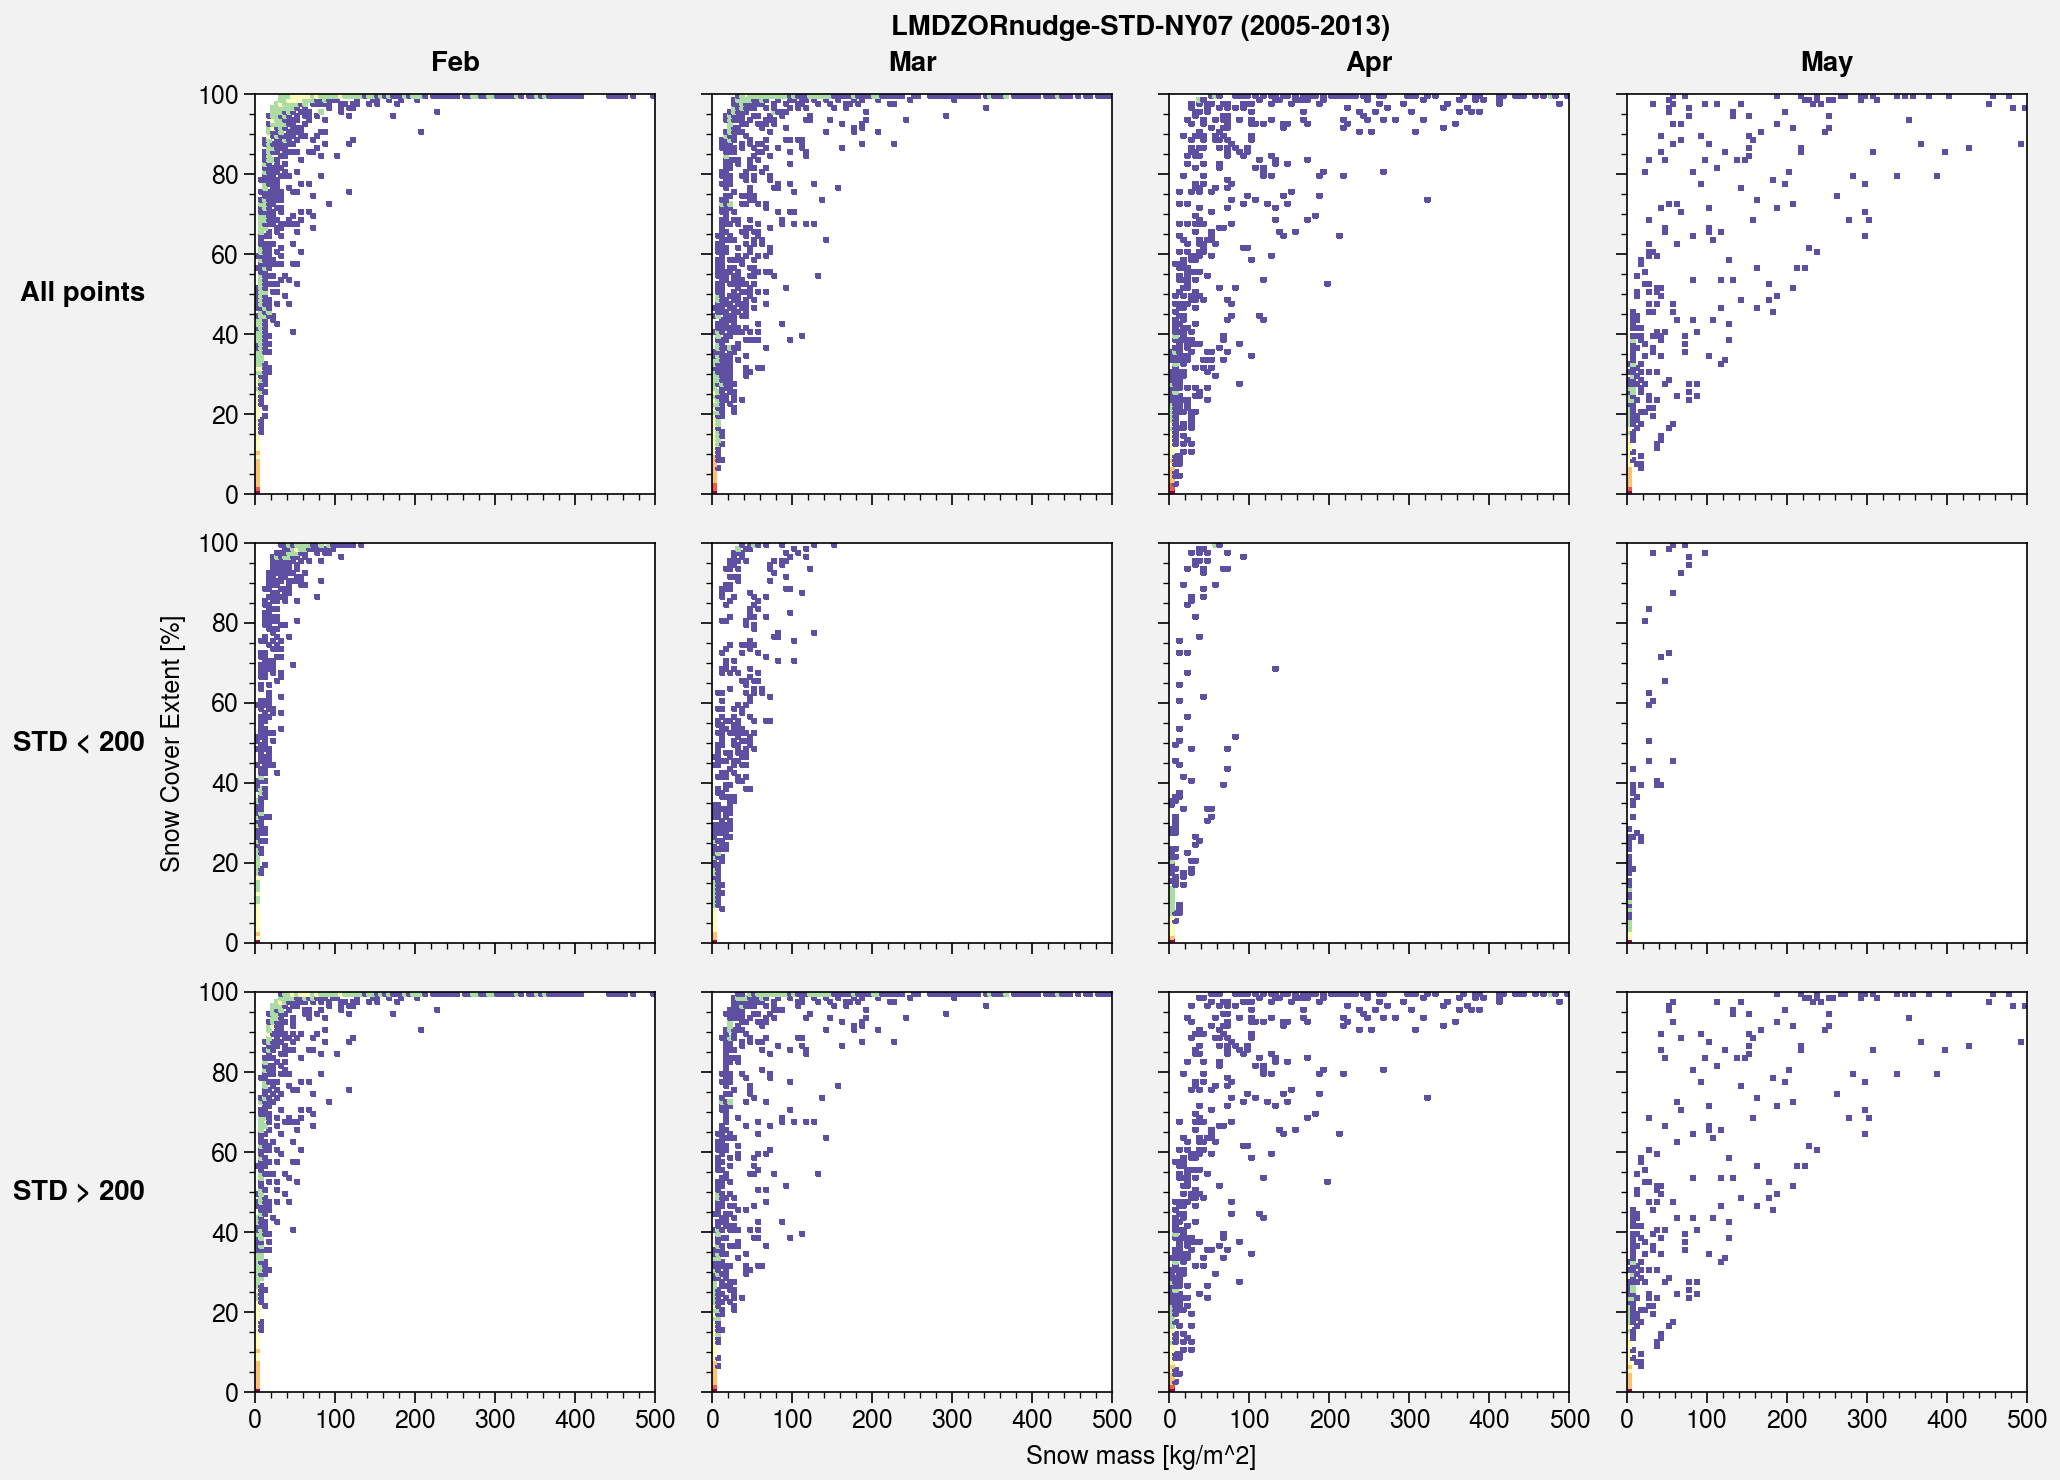

In [17]:
fig, axs = plot.subplots(nrows=3, ncols=4, axwidth=2)

xylim = [[0, 500], [0, 100]]
bins = 100
cmap = 'Spectral_r'
norm = 'log'
vmin=1
cmin=1


k = 0
# All points
for month in range(2,6):
    m = axs[k].hist2d(
        snow_ref.where(snow_ref['time.month'] == month, drop=True).values.flatten(), 
        frac_snow_ref.where(snow_ref['time.month'] == month, drop=True).values.flatten(), 
        bins=bins, range=xylim, cmap=cmap, norm=norm, vmin=vmin, cmin=cmin
    )
    k += 1

# STD < 200
for month in range(2,6):
    m = axs[k].hist2d(
        snow_ref.where(
            (snow_ref['time.month'] == month) & (std < 200),
             drop=True
        ).values.flatten(), 
        frac_snow_ref.where(snow_ref['time.month'] == month, drop=True).values.flatten(), 
        bins=bins, range=xylim, cmap=cmap, norm=norm, vmin=vmin, cmin=cmin
    )
    k += 1

# STD > 200
for month in range(2,6):
    m = axs[k].hist2d(
        snow_ref.where(
            (snow_ref['time.month'] == month) & (std > 200),
             drop=True
        ).values.flatten(), 
        frac_snow_ref.where(snow_ref['time.month'] == month, drop=True).values.flatten(), 
        bins=bins, range=xylim, cmap=cmap, norm=norm, vmin=vmin, cmin=cmin
    )
    k += 1

axs.format(
    collabels=['Feb', 'Mar', 'Apr', 'May'],
    rowlabels=['All points', 'STD < 200', 'STD > 200'],
    xlabel=snow_ref.long_name + ' [' + snow_ref.units + ']',
    ylabel='Snow Cover Extent [' + frac_snow_ref.units + ']',
    suptitle=snow_ref.attrs['title'] + ' (' + period.start + '-' + period.stop + ')'
)

# for extension in ['jpg', 'png', 'pdf']:
#     fig.save(
#         'img/SCE-SWE_' +
#         zone +
#         '_Feb-May_' +
#         period.start + '-' + period.stop +
#         '_' +
#         snow_ref.attrs['title'] +
#         '.' +
#         extension)

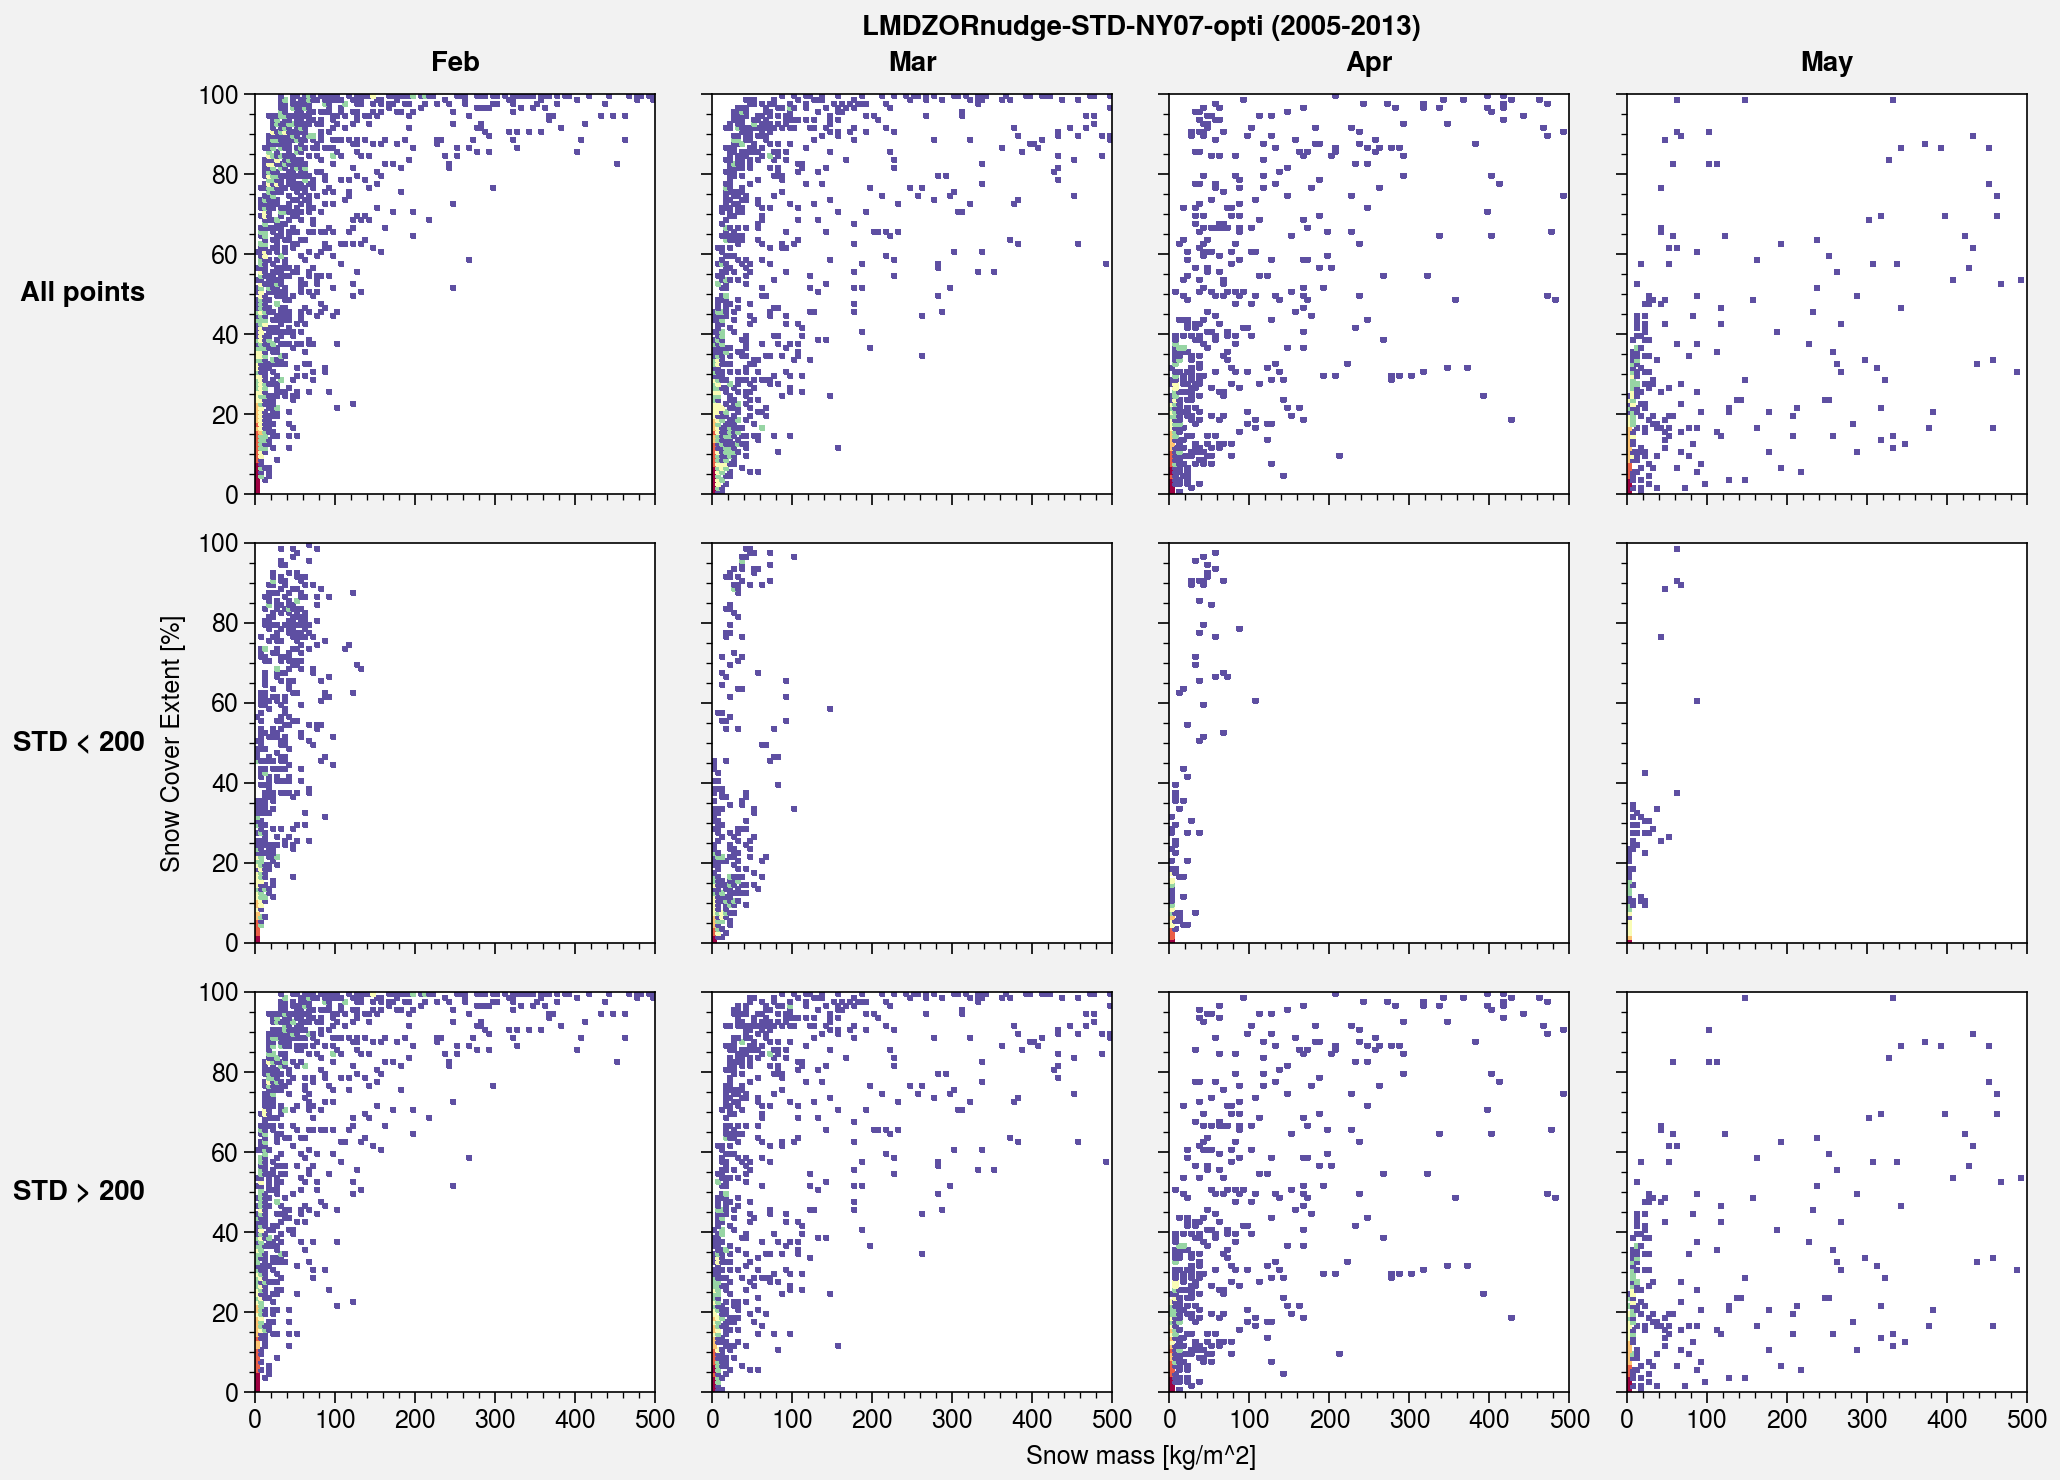

In [18]:
fig, axs = plot.subplots(nrows=3, ncols=4, axwidth=2)

xylim = [[0, 500], [0, 100]]
bins = 100
cmap = 'Spectral_r'
norm = 'log'
vmin=1
cmin=1


k = 0
# All points
for month in range(2,6):
    m = axs[k].hist2d(
        snow_new.where(snow_new['time.month'] == month, drop=True).values.flatten(), 
        frac_snow_new.where(snow_new['time.month'] == month, drop=True).values.flatten(), 
        bins=bins, range=xylim, cmap=cmap, norm=norm, vmin=vmin, cmin=cmin
    )
    k += 1

# STD < 200
for month in range(2,6):
    m = axs[k].hist2d(
        snow_new.where(
            (snow_new['time.month'] == month) & (std < 200),
             drop=True
        ).values.flatten(), 
        frac_snow_new.where(snow_new['time.month'] == month, drop=True).values.flatten(), 
        bins=bins, range=xylim, cmap=cmap, norm=norm, vmin=vmin, cmin=cmin
    )
    k += 1

# STD > 200
for month in range(2,6):
    m = axs[k].hist2d(
        snow_new.where(
            (snow_new['time.month'] == month) & (std > 200),
             drop=True
        ).values.flatten(), 
        frac_snow_new.where(snow_new['time.month'] == month, drop=True).values.flatten(), 
        bins=bins, range=xylim, cmap=cmap, norm=norm, vmin=vmin, cmin=cmin
    )
    k += 1

axs.format(
    collabels=['Feb', 'Mar', 'Apr', 'May'],
    rowlabels=['All points', 'STD < 200', 'STD > 200'],
    xlabel=snow_new.long_name + ' [' + snow_new.units + ']',
    ylabel='Snow Cover Extent [' + frac_snow_new.units + ']',
    suptitle=snow_new.attrs['title'] + ' (' + period.start + '-' + period.stop + ')'
)

# for extension in ['jpg', 'png', 'pdf']:
#     fig.save(
#         'img/SCE-SWE_' +
#         zone +
#         '_Feb-May_' +
#         period.start + '-' + period.stop +
#         '_' +
#         snow_new.attrs['title'] +
#         '.' +
#         extension)